In [273]:
import os
import glob
import subprocess
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [274]:
!mkdir folder_2

mkdir: cannot create directory ‘folder_2’: File exists


In [275]:

# directory
directory = '/content/folder_2'

# List all files in the directory
files = os.listdir(directory)
print("Files in directory:", files)

# Load each file if it's a .mat file
for file in files:
    if file.endswith('.mat'):
        file_path = os.path.join(directory, file)
        data = scipy.io.loadmat(file_path)
        print(f"Loaded {file} with keys: {data.keys()}")


Files in directory: ['OR021_6_1_239.mat', 'OR007_6_1_136.mat', 'sample_data', 'B014_1_190.mat', 'IR021_1_214.mat', 'IR014_1_175.mat', 'OR014_6_1_202.mat', '.ipynb_checkpoints', 'B007_1_123.mat', 'Normal_1_098.mat', 'IR007_1_110.mat', 'B021_1_227.mat']
Loaded OR021_6_1_239.mat with keys: dict_keys(['__header__', '__version__', '__globals__', 'X239_DE_time', 'X239_FE_time', 'X239RPM'])
Loaded OR007_6_1_136.mat with keys: dict_keys(['__header__', '__version__', '__globals__', 'X136_DE_time', 'X136_FE_time', 'X136RPM'])
Loaded B014_1_190.mat with keys: dict_keys(['__header__', '__version__', '__globals__', 'X190_DE_time', 'X190_FE_time', 'X190RPM'])
Loaded IR021_1_214.mat with keys: dict_keys(['__header__', '__version__', '__globals__', 'X214_DE_time', 'X214_FE_time', 'X214RPM'])
Loaded IR014_1_175.mat with keys: dict_keys(['__header__', '__version__', '__globals__', 'X217', 'X217_DE_time', 'X175_DE_time', 'X175_FE_time', 'X175RPM'])
Loaded OR014_6_1_202.mat with keys: dict_keys(['__header

In [156]:
data.items()

dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri Jan 28 10:52:35 2000'), ('__version__', '1.0'), ('__globals__', []), ('X098_DE_time', array([[ 0.046104  ],
       [-0.03713354],
       [-0.089496  ],
       ...,
       [-0.09909231],
       [-0.10827138],
       [-0.07092923]])), ('X098_FE_time', array([[ 0.02321636],
       [ 0.08115455],
       [ 0.09533091],
       ...,
       [-0.00760182],
       [ 0.04026909],
       [ 0.06102   ]]))])

In [157]:

def build_ann_model(X, no_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(no_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [192]:
def build_cnn_model(X, no_classes):
    inputs = [tf.keras.Input(shape=(X.shape[1], X.shape[2])) for _ in range(3)]
    layers = []
    for idx, kernel_size in enumerate([200, 100, 50]):
        conv = tf.keras.layers.Conv1D(filters=64, kernel_size=kernel_size, activation="relu")(inputs[idx])
        drop = tf.keras.layers.Dropout(0.5)(conv)
        pool = tf.keras.layers.MaxPooling1D(pool_size=20 // (idx + 1))(drop)
        flat = tf.keras.layers.Flatten()(pool)
        layers.append(flat)
    merged = tf.keras.layers.concatenate(layers)
    outputs = tf.keras.layers.Dense(no_classes, activation="softmax")(
        tf.keras.layers.Dense(100, activation="relu")(merged)
    )
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return cnn_model


In [159]:
def build_adcnn_model(input_shape, no_classes):
    model = tf.keras.models.Sequential([
# All convolutional layers with single filter
        tf.keras.layers.Conv1D(filters=1, kernel_size=3, padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=1, kernel_size=3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=1, kernel_size=3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(no_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [160]:
def train_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=10, num_inputs=1):
    return model.fit([X_train] * num_inputs, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([X_test] * num_inputs, y_test), shuffle=True)


In [161]:

def predict(model, X_test, num_inputs=1):
    return model.predict([X_test] * num_inputs)


In [162]:
def inv_transform_result(y_pred, encoder):
    return encoder.inverse_transform(np.argmax(y_pred, axis=1))


In [163]:

def plot_confusion_matrix(Y_test, Y_pred, encoder):
    cm = confusion_matrix(Y_test, Y_pred, normalize="true")
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.show()

In [164]:
def read_and_preprocess_data(directory, win_len, stride):
    df = pd.DataFrame(columns=["DE_data", "fault"])
    for file_path in glob.glob(f"{directory}/*.mat", recursive=True):
        mat = scipy.io.loadmat(file_path)
        key_name = next((key for key in mat.keys() if 'DE_time' in key), None)
        if key_name:
            DE_data = mat[key_name].squeeze()
            fault = np.full((len(DE_data), 1), os.path.basename(file_path)[:-4])
            df_temp = pd.DataFrame({"DE_data": DE_data, "fault": fault.ravel()})
            df = pd.concat([df, df_temp], axis=0)
    encoder = LabelEncoder().fit(df["fault"])
    X, Y = [], []
    for k in df["fault"].unique():
        df_temp_2 = df[df["fault"] == k]
        for i in range(0, len(df_temp_2) - win_len, stride):
            temp = df_temp_2.iloc[i:i + win_len, :-1].values
            temp = temp.reshape((1, -1))
            X.append(temp)
            Y.append(df_temp_2.iloc[i + win_len - 1, -1])

    X = np.array(X).reshape((-1, win_len, 1))
    Y = to_categorical(encoder.transform(np.array(Y)))
    return X, Y, df, encoder

In [165]:
#window length and stride
win_len = 784
stride = 300

def plot_data(df):
    plt.figure(figsize=(15, 5))
    sns.scatterplot(data=df.iloc[::100, :], y="DE_data", x=np.arange(0, len(df), 100), hue="fault")
    plt.legend(title='Fault Type', loc='lower right', bbox_to_anchor=(1.2, 0))
    plt.show()


def split_data(X, Y, test_size=0.2):
    return train_test_split(X, Y, test_size=test_size, shuffle=True)

In [166]:
# path
path = '/content/folder_2'
epochs = 10

# Call the function preprocess the data
X, Y, df, encoder = read_and_preprocess_data(path, win_len, stride)

print("Shape of feature matrix X:", X.shape)
print("Shape of labels Y:", Y.shape)
print("Sample labels after encoding:", Y[:5])

print(df.head())


Shape of feature matrix X: (16197, 784, 1)
Shape of labels Y: (16197, 10)
Sample labels after encoding: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
    DE_data          fault
0  0.040064  OR021_6_1_239
1  0.021701  OR021_6_1_239
2 -0.020867  OR021_6_1_239
3 -0.065104  OR021_6_1_239
4 -0.111845  OR021_6_1_239


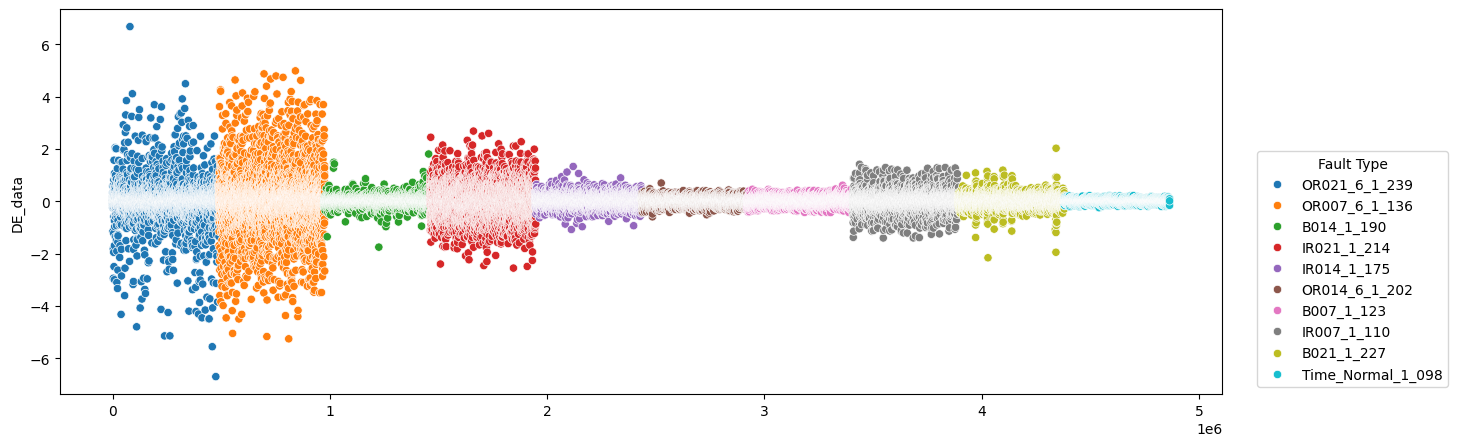

In [167]:
#plot the data
plot_data(df)


In [168]:
X_train, X_test, y_train, y_test = split_data(X, Y, test_size=0.3)

In [169]:
Y_test = inv_transform_result(y_test, encoder)

In [186]:
cnn_model = build_cnn_model(X, no_classes=len(df['fault'].unique()))
cnn_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 784, 1)]             0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 784, 1)]             0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 784, 1)]             0         []                            
                                                                                                  
 conv1d_24 (Conv1D)          (None, 585, 64)              12864     ['input_14[0][0]']            
                                                                                            

In [193]:
history = train_model(cnn_model, X_train, y_train, X_test, y_test, batch_size=100, epochs=epochs, num_inputs=3)


Epoch 1/10
114/114 [==============================] - 64s 522ms/step - loss: 0.7969 - accuracy: 0.7127 - val_loss: 0.2621 - val_accuracy: 0.9574
Epoch 2/10
114/114 [==============================] - 60s 527ms/step - loss: 0.0880 - accuracy: 0.9738 - val_loss: 0.1207 - val_accuracy: 0.9835
Epoch 3/10
114/114 [==============================] - 57s 502ms/step - loss: 0.0368 - accuracy: 0.9891 - val_loss: 0.0831 - val_accuracy: 0.9862
Epoch 4/10
114/114 [==============================] - 60s 524ms/step - loss: 0.0316 - accuracy: 0.9898 - val_loss: 0.0704 - val_accuracy: 0.9872
Epoch 5/10
114/114 [==============================] - 58s 507ms/step - loss: 0.0166 - accuracy: 0.9955 - val_loss: 0.0620 - val_accuracy: 0.9891
Epoch 6/10
114/114 [==============================] - 58s 508ms/step - loss: 0.0138 - accuracy: 0.9964 - val_loss: 0.0418 - val_accuracy: 0.9934
Epoch 7/10
114/114 [==============================] - 60s 529ms/step - loss: 0.0950 - accuracy: 0.9833 - val_loss: 0.1166 - val_ac

In [195]:
y_pred = predict(cnn_model, X_test, num_inputs=3)

152/152 [==============================] - 10s 66ms/step


In [196]:
Y_pred = inv_transform_result(y_pred, encoder)

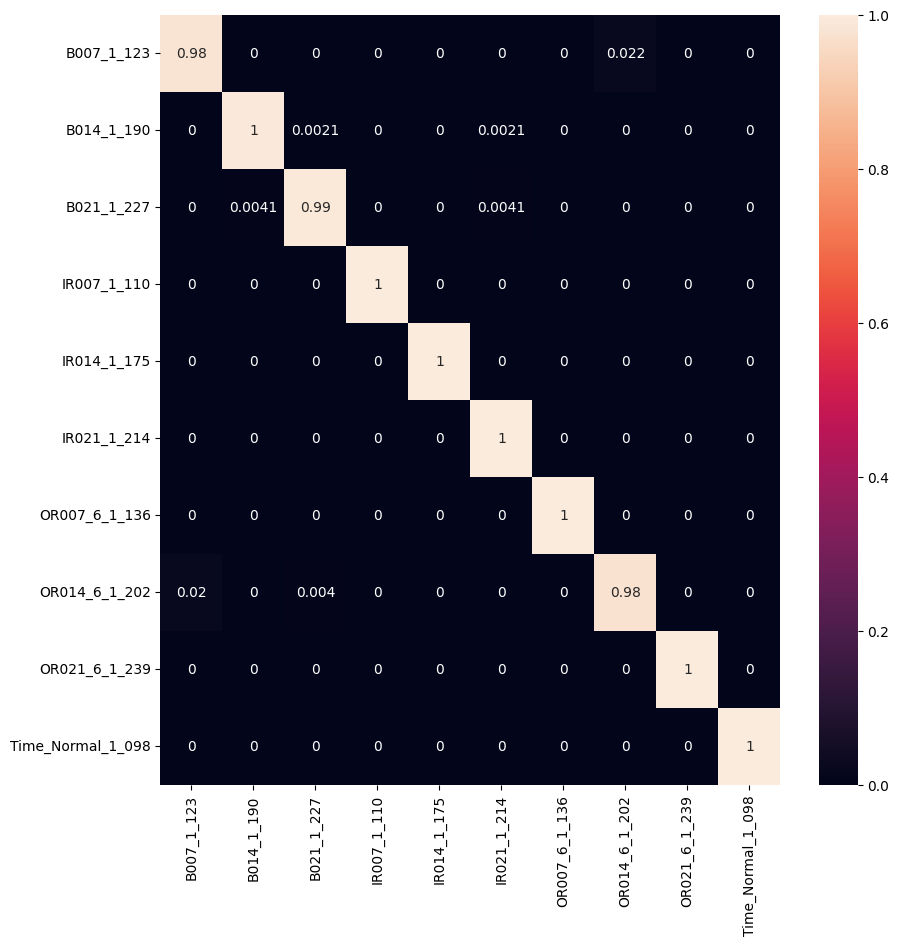

In [197]:
plot_confusion_matrix(Y_test, Y_pred, encoder)

In [198]:
X_train_ann = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_ann = X_test.reshape(X_test.shape[0], X_test.shape[1])
ann_model = build_ann_model(X_train_ann, len(df["fault"].unique()))
ann_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               100480    
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [176]:
history_ann = train_model(ann_model, X_train_ann, y_train, X_test_ann, y_test, batch_size=100, epochs=epochs, num_inputs=1)

Epoch 1/10
114/114 [==============================] - 2s 8ms/step - loss: 1.7207 - accuracy: 0.3807 - val_loss: 1.2173 - val_accuracy: 0.6510
Epoch 2/10
114/114 [==============================] - 1s 6ms/step - loss: 0.7583 - accuracy: 0.8224 - val_loss: 0.4517 - val_accuracy: 0.8961
Epoch 3/10
114/114 [==============================] - 1s 6ms/step - loss: 0.2847 - accuracy: 0.9421 - val_loss: 0.2395 - val_accuracy: 0.9387
Epoch 4/10
114/114 [==============================] - 1s 6ms/step - loss: 0.1507 - accuracy: 0.9696 - val_loss: 0.1690 - val_accuracy: 0.9519
Epoch 5/10
114/114 [==============================] - 1s 6ms/step - loss: 0.0935 - accuracy: 0.9807 - val_loss: 0.1493 - val_accuracy: 0.9496
Epoch 6/10
114/114 [==============================] - 1s 5ms/step - loss: 0.0641 - accuracy: 0.9889 - val_loss: 0.1218 - val_accuracy: 0.9626
Epoch 7/10
114/114 [==============================] - 1s 6ms/step - loss: 0.0431 - accuracy: 0.9947 - val_loss: 0.1121 - val_accuracy: 0.9601
Epoch 

In [177]:
y_pred_ann = predict(ann_model, X_test_ann, num_inputs=1)

152/152 [==============================] - 0s 3ms/step


In [178]:
Y_pred_ann = inv_transform_result(y_pred_ann, encoder)

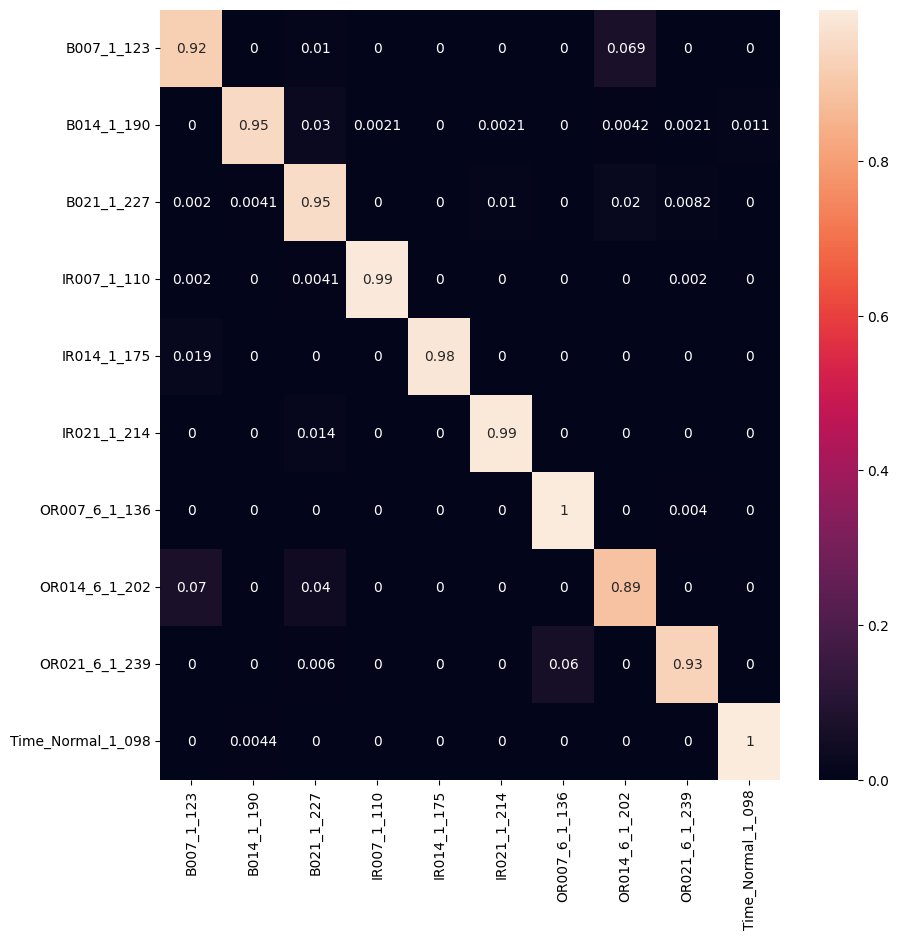

In [179]:
plot_confusion_matrix(Y_test, Y_pred_ann, encoder)

In [180]:
X_train_adcnn = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_adcnn = X_test.reshape(X_test.shape[0], X_test.shape[1])
adcnn_model = build_ann_model(X_train_ann, len(df["fault"].unique()))
adcnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 128)               100480    
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [181]:
history_adcnn = train_model(ann_model, X_train_ann, y_train, X_test_ann, y_test, batch_size=100, epochs=epochs, num_inputs=1)

Epoch 1/10
114/114 [==============================] - 1s 7ms/step - loss: 0.0704 - accuracy: 0.9824 - val_loss: 0.1721 - val_accuracy: 0.9527
Epoch 2/10
114/114 [==============================] - 1s 6ms/step - loss: 0.0308 - accuracy: 0.9936 - val_loss: 0.1119 - val_accuracy: 0.9613
Epoch 3/10
114/114 [==============================] - 1s 6ms/step - loss: 0.0127 - accuracy: 0.9982 - val_loss: 0.0907 - val_accuracy: 0.9687
Epoch 4/10
114/114 [==============================] - 1s 6ms/step - loss: 0.0080 - accuracy: 0.9997 - val_loss: 0.0892 - val_accuracy: 0.9677
Epoch 5/10
114/114 [==============================] - 1s 6ms/step - loss: 0.0057 - accuracy: 0.9999 - val_loss: 0.0849 - val_accuracy: 0.9706
Epoch 6/10
114/114 [==============================] - 1s 6ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0826 - val_accuracy: 0.9730
Epoch 7/10
114/114 [==============================] - 1s 6ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0812 - val_accuracy: 0.9720
Epoch 

In [211]:
y_pred_adcnn = predict(model, X_test, num_inputs=1)

10/10 [==============================] - 0s 7ms/step


In [200]:
Y_pred_adcnn = inv_transform_result(y_pred_ann, encoder)

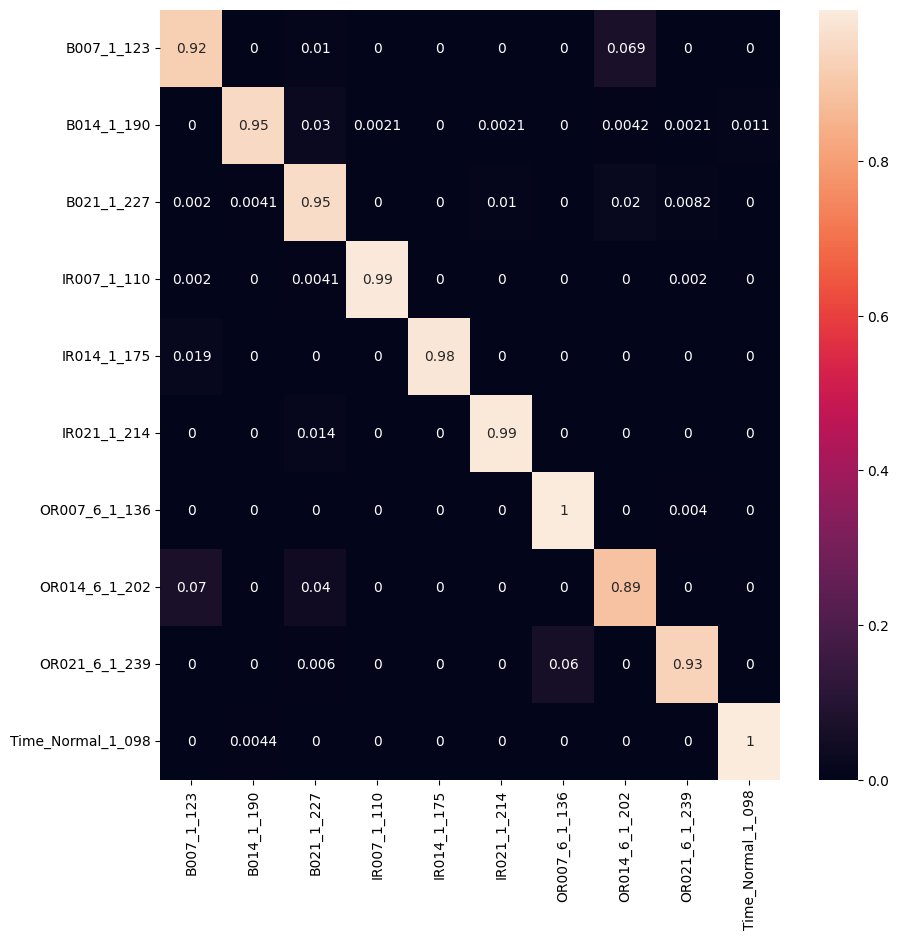

In [183]:
plot_confusion_matrix(Y_test, Y_pred_adcnn, encoder)